Author: Franklin Williams  
Contact: streater@uw.edu  
Institution: University of Washington, CFRM 2020  
Source Code: https://www.github.com/streater512/MLforFinance

# Abstract

Traditional pairs trading strategies rely on strict assumptions about the relationships between securities, namely that there exists a linear relationship between candidate securities. By utilizing measurements from information theory, securities are tested for the existence of polynomial relationships. Pairs with strong relationships are chosen and dollar neutral portfolios are traded. The portfolio of portfolios is found to outperform the S&P 500 index in both in-sample and out-of-sample backtests, in terms of absolute performance, Sharpe ratio, and relative drawdown.


# Introduction

Pairs trading is a form of statistical arbitrage where portfolio managers attempt to profit on the price spread convergence of related securities. Traditional pairs trading approaches consist four stages: security identification, spread modeling, trade signal generation, and portfolio construction. Typically, two or more highly correlated securities are selected as candidates for portfolio construction. Common examples include Coca-Cola (KO)/ Pepsi (PEP) and Exxon Mobil (XOM)/ Chevron Corp (CVX). Once candidate securities are selected, a time series of the price spread is calculated. Traditionally this is done by ordinary least squares to find the linear relationship between securities. The time series is then tested for mean reversion and stationary properties. These characteristics allow the portfolio manager to develop trading signals for the individual securities. One example of a trading signal is entering a long position on the underperforming security and a short position on the outperforming security when the spread reaches a predetermined level. Next, portfolio of the securities is created, such that the portfolio manager has zero dollar exposure to the market. The manager builds a dollar neutral portfolio by entering long and short positions of equal market value. As the spread converges, the dollar neutral portfolio increases in value. 

This research relaxes the assumption of linear relationships between securities and utilizes the mutual information between candidate securities to test securities for polynomial relationships. The mutual information of two random variables measures the mutual dependence between two variables and is often used as a generalized version of correlation. Securities with high mutual information indicate the existence of either a linear or nonlinear relationship which can be utilized to generate a dollar neutral portfolio.

The research notebook is divided into the following sections:
<ol>
    <li>Data Collection and Cleaning </li>
    <li>Potential Pair Selection </li>
    <li>Spread Modeling</li>
    <li>Mean Reversion and Stationarity Testing</li>
    <li>Trade Signal Generation </li>
    <li>Backtest Methodology </li>
    <li>Performance Summary </li>
    <li>Conclusion </li>
</ol>


## Load Required Packages

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from itertools import combinations
from sklearn.base import BaseEstimator
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mutual_info_score
import random 
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm
import warnings
from arch.unitroot import PhillipsPerron, VarianceRatio
from mlfinlab.labeling.trend_scanning import trend_scanning_labels
from collections import defaultdict
import yfinance as yf
import datetime
from mutual_information_pairs_functions import *

# Data Collection and Cleaning
## Data Source: [Quandl Shrader Database](https://www.quandl.com/databases/SFB/data)

In [2]:
prices = pd.read_csv("sample_US_equity_close.csv", index_col=0)
sample = 200
sample_securities = prices.columns[:sample]

train = prices[:'2018'][sample_securities]
test = prices['2018':][sample_securities]

penny_stock_price = 5 # Exclude penny stocks from analysis
train = train[train>penny_stock_price].dropna(axis=1)
test = test[train.columns]
securities = train.columns
n_securities = len(securities)
train.head()

,UVSP,CBSH,MMLP,LOGN,CRDF,CUB,CZNC,TILE,KLAC,GLT,...,HIFS,AXP,LFUS,STRS,FMX,PRFT,DTE,GIS,CCU,MET
date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,17.75,26.586,31.990,12.4,328.319,39.15,9.65,8.66,36.92,12.68,...,30.56,40.92,33.58,11.29,49.90,8.70,43.54,35.45,15.712,36.30
2010-01-05,16.86,26.539,32.370,12.4,323.999,41.58,9.55,8.56,36.51,13.18,...,30.50,40.83,32.42,11.00,48.71,8.61,43.05,35.12,15.748,37.14
2010-01-06,16.78,26.437,32.720,12.4,319.679,41.02,9.27,8.34,36.37,13.22,...,32.73,41.49,32.37,10.38,49.39,8.58,43.23,35.33,16.004,37.52
2010-01-07,17.12,27.060,32.950,12.4,323.999,40.26,9.03,8.43,36.57,13.22,...,32.73,41.98,32.38,9.64,50.01,8.54,42.83,35.65,16.264,38.05
2010-01-08,17.17,26.722,32.839,12.4,323.999,40.76,9.23,8.48,37.12,13.62,...,32.75,41.95,32.65,9.39,49.77,8.56,43.16,35.36,16.556,38.25


# Potential Pair Selection
The mutual information for each unique pair of securities is calculated. Securities in the top quantile are chosen as securities with the strongest relationship among the sample.  The mutual information of the pair is defined as: 

<br>
<center> $\begin{aligned}I[X,Y] = H[X] - H[X|Y] &= H[X] + H[Y] - H[X, Y] \\ 
       &= \displaystyle\sum_{x \in S_x}\displaystyle\sum_{y \in S_y}p[x,y]\log\big[\frac{p[x,y]}{p[x]p[y]}\big]\end{aligned}$ 
</center>
Where $p[x,y]$ is the probability mass function of $X$ and $Y$.
<br>
$p[x]$ and $p[y]$ are the marginal probability density functions of $X$ and $Y$ respectiely.

Pairs with a mutual information score above an arbitrary cutoff are selected. In this example, securities in the top decile are selected.

In [3]:
pairs = list(combinations(securities, 2))
pairs_list = []
for pair in pairs:
    pairs_list.append(convertTuple(pair))
pairs_list[:5] # Print example

['UVSP-CBSH', 'UVSP-MMLP', 'UVSP-LOGN', 'UVSP-CRDF', 'UVSP-CUB']

In [4]:
try:
    mutual_info_df = pd.read_csv(f'mutual_info_{n_securities}.csv', index_col=0)
    print('mutual_info_df loaded')
except FileNotFoundError:
    print('Calculating mutual_info_df')
    mutual_info_df = calculate_mutual_information(pairs, pairs_list, train)
    mutual_info_df.to_csv(f'mutual_info_{n_securities}.csv')

mutual_info_df loaded


## Plot Mutual Information Scores

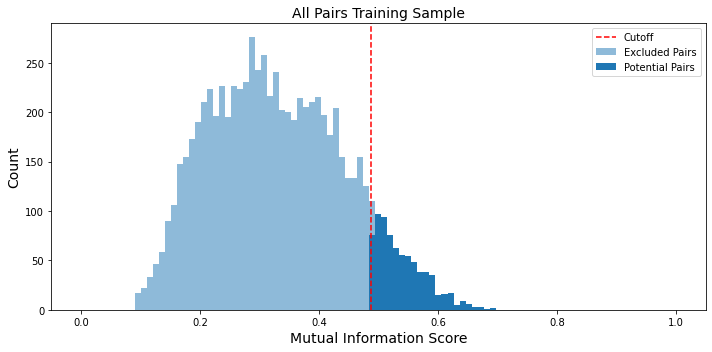

In [5]:
top_quantile = mutual_info_df.quantile(0.9)
potential_pairs = mutual_info_df[mutual_info_df >= top_quantile].dropna()
plot_potential_pairs_hist(mutual_info_df, potential_pairs)

# Spread Modeling

To estimate the relationship between the potential pairs, polynomial regression is conducted. For each potential pair, a grid search over five degrees is performed by regressing the price pairs. To avoid overfitting the model, the polynomial regression that has the lowest mean squared error across a five-fold cross validation is chosen. From the bar chart below, the majority of the estimated relationships are linear while the remaining are nonlinear. This indicates that while a linear relationship is a valid assumption for certain pairs, the assumption does not capture certain relationships between securities in the market. The polynomial regression allows the strategy to more accurately model the spread relationships between potential pairs.


In [6]:
try:
    cv_models = pd.read_csv(f'cv_models_{n_securities}.csv', index_col=0)
    cv_predicted = pd.read_csv(f'cv_predicted_{n_securities}.csv', index_col=0)
    cv_spreads_train = pd.read_csv(f'cv_spreads_train_{n_securities}.csv', index_col=0)
    cv_spreads_test = pd.read_csv(f'cv_spreads_test_{n_securities}.csv', index_col=0)
    
    print('cv_models loaded')
    print('cv_predicted loaded')
    print('cv_spreads_train loaded')
    print('cv_spreads_test loaded')
except FileNotFoundError:
    print('Generating cross-validated dataframes')
    potential_pairs_tuples = []
    for pair in potential_pairs.index:
        potential_pairs_tuples.append(convertString(pair))

    cv_predicted, cv_models, cv_spreads_train, cv_spreads_test = generate_cv_dataframes(potential_pairs_tuples, 
                                                                                        potential_pairs.index,
                                                                                        train,
                                                                                        test)

cv_models loaded
cv_predicted loaded
cv_spreads_train loaded
cv_spreads_test loaded


## Plot Polynomial Models

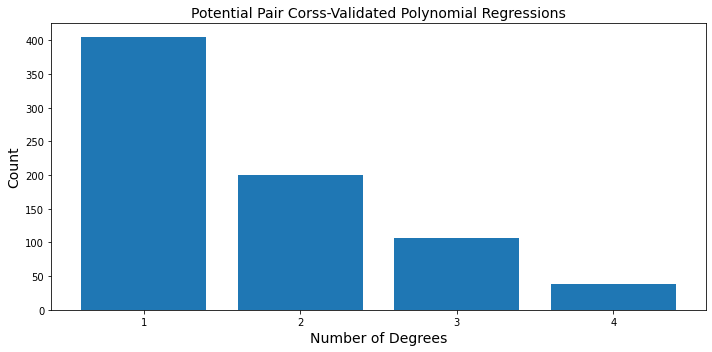

In [7]:
plot_cv_model_degrees(cv_models)

# Mean Reversion and Stationarity Testing

Pairs trading strategies profit when the modeled spreads revert to the mean. In this section, the modeled spreads are tested rigorously for mean reversion and stationarity properties. A mean reverting spread creates profitable trading opportunities. If spreads are predicted to revert to the mean, market neutral portfolios are created by entering long positions in the underperforming security and short positions in the outperforming security. Stationary spreads are also desirable because it indicates the existence of a mean and constant volatility. Stationary spreads are expected to revert to the mean and not diverge. If spreads continue to diverge, the constructed portfolios decrease in value because the either the long position decreases in value more than the short position increases, vice versa, or both legs of the market neutral portfolio decrease in value. 


## Mean Reversion Statistics

Two statistics are chosen to test for the presence of viable mean reverting pairs: the Hurst exponent and the spreads half-life. 

The Hurst exponent, H, is used to measure the long-term memory of a time series. A value in the range of [0-0.5) indicates that a time series reverts strongly to the mean while a value of [0.5-1] indicates a time series with long-term positive autocorrelation and is likely to diverge. The Hurst exponent is calculated as: 

<br>
<center> $\begin{aligned} \mathbb{E}\big[\frac{R(n)}{S(n)}\big] = Cn^H , n \rightarrow \infty\end{aligned}$</center>
$R(n)$ is the range of the first $n$ cumulative deviations from the mean.  
$S(n)$ is the series of the first $n$ standard deviations.  
$\mathbb{E}$ is the expected value.  
$n$ is the number of observations in the time series.  
$C$ is a constant.  

The half-life of a series is the amount of time it takes for a series to return to half its initial value and is defined as: 

<br>
<center> $\begin{aligned} N(t) = N_0e^{-\lambda t} \end{aligned}$</center>
$N_0$ is the initial quantity of the spread that will decay.  
$N(t)$ is the quantity that still remains and has not yet decayed after a time $t$.  
$\lambda$ is a positive number called the decay constant.  

The half-life, $t_{1/2}$ is defined as:
<center> $\begin{aligned} t_{1/2} = \frac{ln(2)}{\lambda} \end{aligned}$</center>


Spreads with short half-lives indicate portfolios that revert to the mean often and create many trading opportunities.

In [8]:
hurst_exponents = []
for col in potential_pairs.index:
    hurst_exp = hurst(cv_spreads_train[col].values)
    hurst_exponents.append(hurst_exp)
    
half_lives = cv_spreads_train[potential_pairs.index].apply(half_life)

cv_hurst_exponents = pd.DataFrame({'hurst_exponent':hurst_exponents}, index=potential_pairs.index)
cv_half_lives = pd.DataFrame({'half_life':half_lives}, index=potential_pairs.index)

## Stationarity Test Statistics

Four stationarity tests are calculated for the modeled spreads:

<ul>
    <li>Augmented Dickey–Fuller: Null hypothesis that a unit root is present in the time series   </li>
    <li>Kwiatkowski–Phillips–Schmidt–Shin: Null hypothesis that the time series is stationary   </li>
    <li>Phillips–Perron: Null hypothesis that a time series is integrated of order 1   </li>
    <li>Lo-Mackinlay Variance Ratio: Null hypothesis that spread follows a random walk   </li>
</ul>
Spreads that reject the Augmented Dickey–Fuller, Phillips–Perron, and Lo-Mackinlay tests indicate that a series is likely stationary. On the other hand, spreads that fail to reject the Kwiatkowski–Phillips–Schmidt–Shin test indicate a series is likely stationary.

In [9]:
cv_stationary_tests = generate_stationarity_dataframe(potential_pairs.index, cv_spreads_train)

In [10]:
cv_test_stats = pd.concat([cv_half_lives, cv_hurst_exponents, cv_stationary_tests], axis=1)
cv_test_stats.describe()

,half_life,hurst_exponent,adf_t_stat,adf_p_value,kpss_t_stat,kpss_p_value,pp_t_stat,pp_p_value,vr_t_stat,vr_p_value
count,751.000000,751.000000,751.000000,7.510000e+02,751.000000,751.000000,751.000000,7.510000e+02,751.000000,7.510000e+02
mean,184.170580,0.404444,-2.904792,1.873108e-01,1.086595,0.037318,-3.195922,1.739395e-01,-1.403625,2.971768e-01
std,1981.543920,0.070952,1.387257,2.824753e-01,0.913761,0.036857,1.662966,2.829283e-01,1.201086,3.043554e-01
min,-3998.762760,0.170974,-8.400352,2.240106e-13,0.054351,0.010000,-12.408751,4.391867e-23,-5.064424,4.096373e-07
25%,33.277151,0.361190,-3.841046,2.514464e-03,0.408501,0.010000,-4.222734,6.029397e-04,-2.198911,2.788467e-02
50%,55.717658,0.407048,-2.992090,3.563971e-02,0.758917,0.010000,-3.213005,1.924412e-02,-1.259220,1.998473e-01
75%,106.467889,0.452470,-2.056751,2.622569e-01,1.468596,0.073491,-2.173836,2.158781e-01,-0.556636,5.057443e-01
max,52453.932986,0.595978,2.847409,1.000000e+00,6.765295,0.100000,3.299714,1.000000e+00,2.087074,9.952195e-01


### Filter Potential Pairs

To select spreads with desirable characteristics, the potential pairs are filtered further based on their mean reverting and stationarity statistics. Spreads with $H < 0.5$ and $1 \leq t_{1/2} \leq 252$ indicate mean reverting pairs with many tradable opportunities.

Additionally, spreads that reject the Augmented Dickey–Fuller, Phillips–Perron, and Lo-Mackinlay tests at the $\alpha = 0.05$ level and fail to reject the Kwiatkowski–Phillips–Schmidt–Shin test at the $\alpha = 0.05$ level are considered stationary.

Of the 751 potential pairs, 80 pairs meet the selected criteria. Below the original prices series for the pair components, scatter plot with estimated polynomial regression, and spread time series are plotted for the first three spreads that meet the above criteria.

In [11]:
alpha_value = 0.05
mean_reversion_value = 0.5
min_half_life = 1.0
max_half_life = 252.0
cv_filtered = cv_test_stats[(cv_test_stats['kpss_p_value'] >= alpha_value) &
                            (cv_test_stats['adf_p_value'] < alpha_value) &
                            (cv_test_stats['pp_p_value'] < alpha_value) &
                            (cv_test_stats['vr_p_value'] < alpha_value) &
                            ((cv_test_stats['half_life'] >= min_half_life) & 
                            (cv_test_stats['half_life'] <= max_half_life )) &
                            (cv_test_stats['hurst_exponent'] < mean_reversion_value)]
filtered_pairs = cv_filtered.index
cv_filtered.describe()

,half_life,hurst_exponent,adf_t_stat,adf_p_value,kpss_t_stat,kpss_p_value,pp_t_stat,pp_p_value,vr_t_stat,vr_p_value
count,80.000000,80.000000,80.000000,8.000000e+01,80.000000,80.000000,80.000000,8.000000e+01,80.000000,80.000000
mean,28.738271,0.355686,-4.317843,5.013659e-03,0.275496,0.094149,-4.912929,2.203094e-03,-2.884136,0.010978
std,11.399013,0.058170,0.857440,1.110395e-02,0.096692,0.012174,1.274825,4.674993e-03,0.620975,0.012880
min,8.151141,0.190213,-7.239323,1.902573e-10,0.054351,0.050488,-9.669490,1.288297e-16,-4.549199,0.000005
25%,20.479402,0.321928,-4.792465,5.624120e-05,0.199478,0.094971,-5.577932,1.434665e-06,-3.286640,0.001016
50%,26.875269,0.361913,-4.239629,5.654390e-04,0.277949,0.100000,-4.707460,8.149785e-05,-2.760113,0.005783
75%,36.542552,0.393168,-3.764230,3.340313e-03,0.358668,0.100000,-3.978316,1.529497e-03,-2.406937,0.016087
max,60.704354,0.487506,-2.865792,4.947297e-02,0.461867,0.100000,-3.154675,2.276283e-02,-2.025887,0.042776


### Plot Filtered Pairs

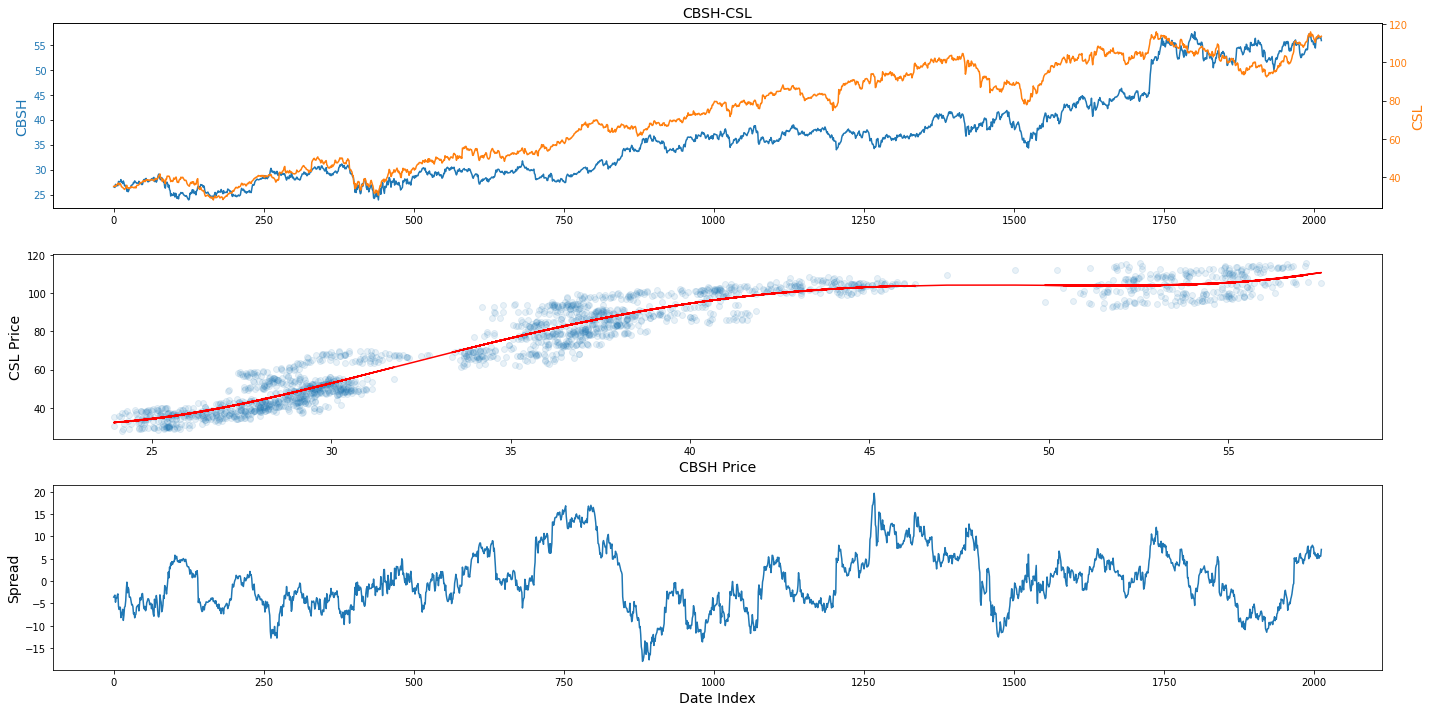

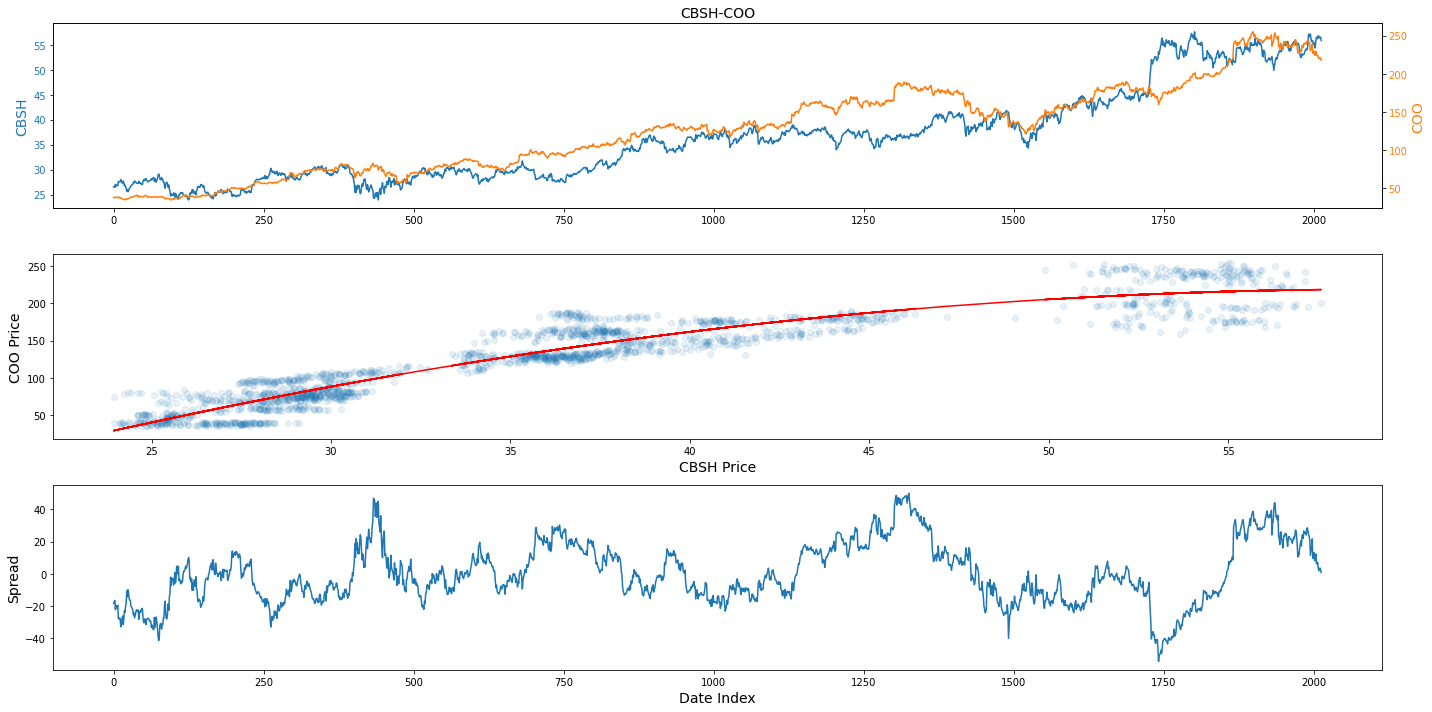

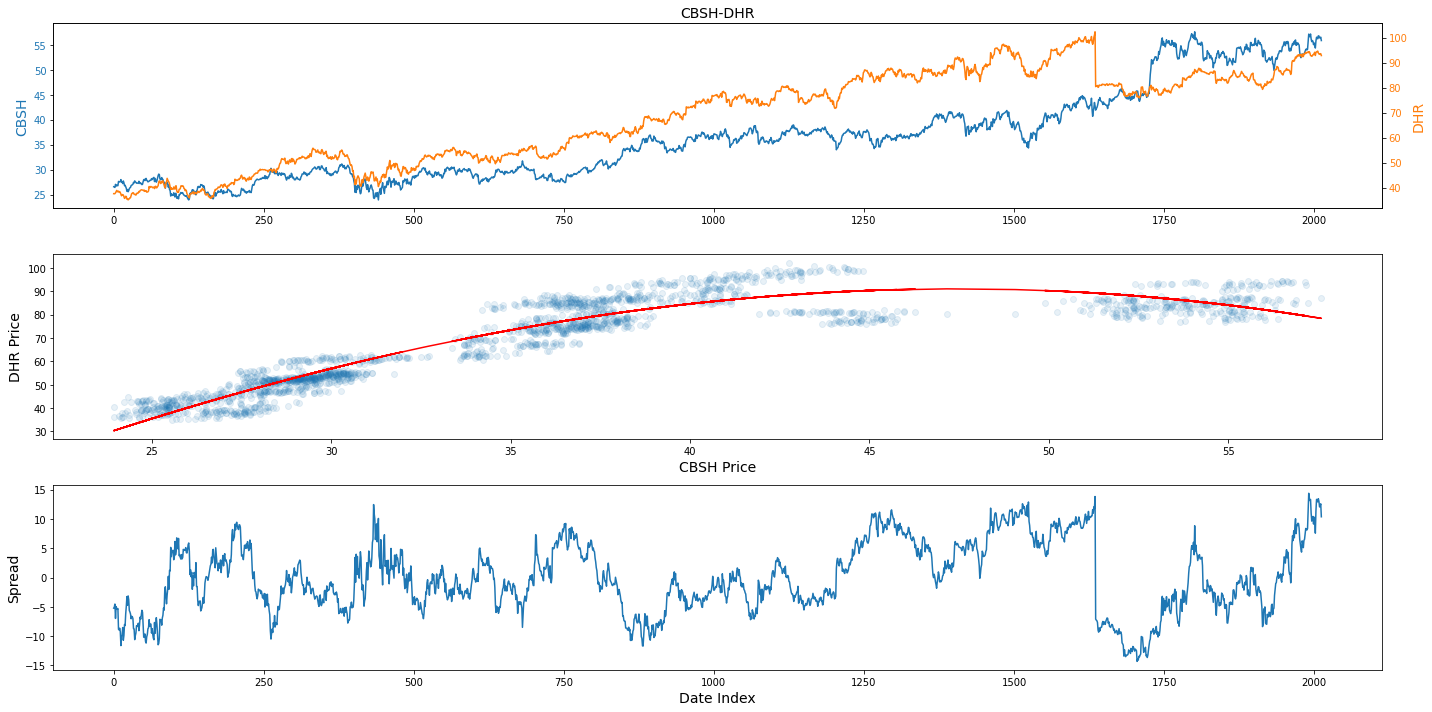

In [12]:
plot_spreads(cv_filtered.index[:3], cv_predicted, cv_spreads_train, train)

# Trade Signal Generation


Using Lopez de Prado’s trend-scanning method [1] trading signals are generated. Given a series of observations $\{x_t\}_{t=1,…,T}$ each observation is assigned a label $y_t \in \{-1, 1\}$ to designate that an observation is part of a downtrend or uptrend. The label is chosen by taking the sign of the $t$-value of the ordinary least squared regression coefficient:

<center> $\begin{aligned} x_{t} &= \beta_0 + \beta_1l + \epsilon_t \\
\hat{t}_{\beta_1} &= \frac{\hat{\beta_1}}{\hat\sigma_{\beta_1}}
\end{aligned}$</center>

$\hat\sigma_{\beta_1}$ is the standard error of $\hat\beta_1$  
$l = L,...,t$ is the lookback period

When the sign of $\hat{t}_{\beta_1}$ is positive (negative), the portfolio is long (short) the spread and the portfolio is long (short) the underperforming (overperforming) security and short (long) the overperforming (underperforming) security.  

Below we plot the spread of the first three tradeable pairs and the positions of the corresponding portfolio.


In [13]:
try:
    trend_labels_train = pd.read_csv(f'trend_labels_train_{n_securities}.csv', index_col=[0,1])
    trend_labels_test = pd.read_csv(f'trend_labels_test_{n_securities}.csv', index_col=[0,1])
    print('trend_labels_train loaded')
    print('trend_labels_test loaded')
except FileNotFoundError:
    print('Generateing trend labels')

    trend_labels_train = generate_trend_labels(filtered_pairs, cv_spreads_train)
    trend_labels_train.to_csv(f'trend_labels_train_{n_securities}.csv')

    trend_labels_test = generate_trend_labels(filtered_pairs, cv_spreads_test)
    trend_labels_test.to_csv(f'trend_labels_test_{n_securities}.csv')

trend_labels_train loaded
trend_labels_test loaded


## Plot Trading Signals

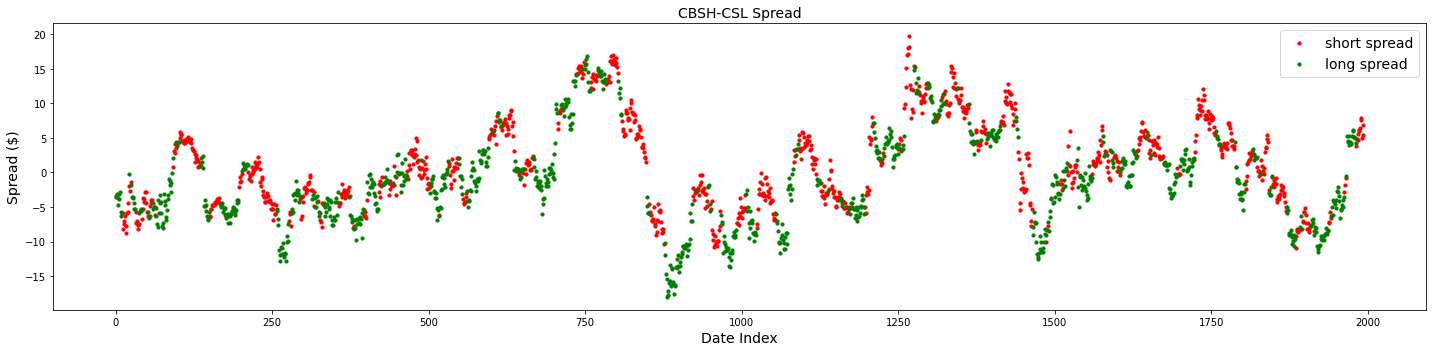

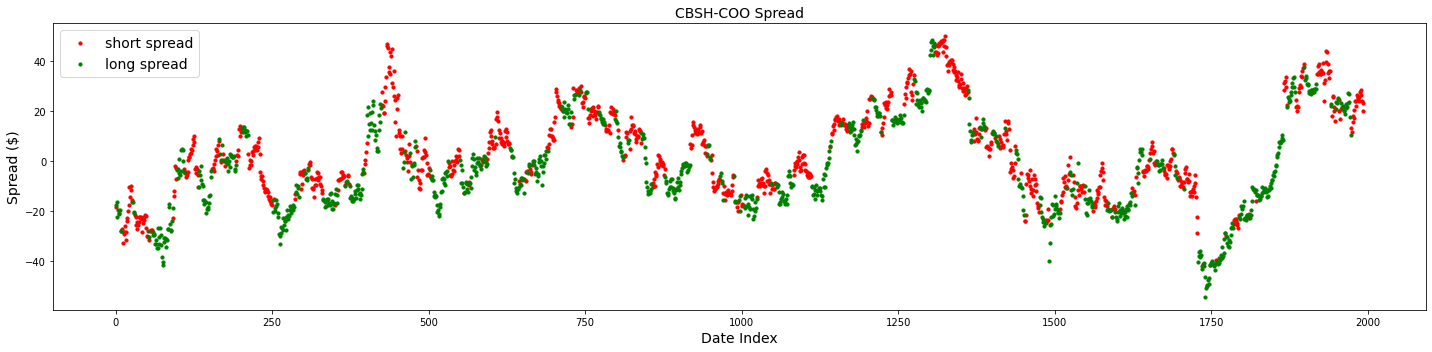

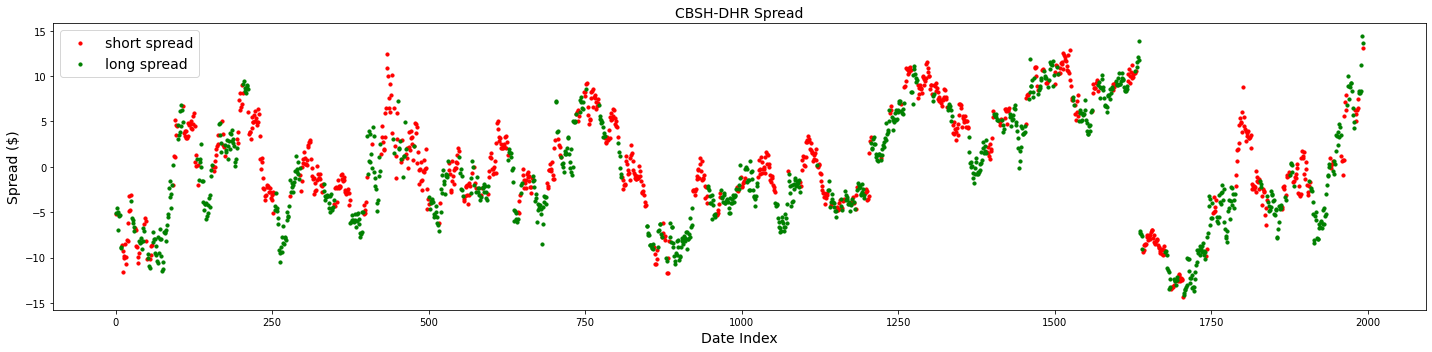

In [14]:
plot_trend_labels(filtered_pairs[:3], cv_spreads_train, trend_labels_train)

# Backtest Methodology

<ol>
    <li>Start with initial wealth, $W_0$ </li>
    <li>Allocate $\frac{W_0}{n}$ to each dollar neutral tradable pair, where $n$ is the number of tradable pairs </li>
    <li>Enter long (short) positions in underperforming (overperforming) securities according to $y_t$ for each spread</li>
    <li>Hold positions until either trade signal changes or margin call required </li>
    <li>On rebalance event, create new dollar neutral portfolio </li>
    <li>Sum wealth, $W_{t,i}$ for each portfolio, $i$, at each time $t$ </li
</ol>







In [15]:
bin_train = pd.DataFrame(trend_labels_train['bin']).dropna()
bin_test = pd.DataFrame(trend_labels_test['bin']).dropna()

In [16]:
try:
    portfolio_df_train = pd.read_csv(f'portfolio_df_train_{n_securities}.csv', index_col=[0,1])
    portfolio_df_test = pd.read_csv(f'portfolio_df_test_{n_securities}.csv', index_col=[0,1])
except FileNotFoundError:
    
    portfolio_df_train = calculate_portfolio_df(filtered_pairs, bin_train, prices,
                                                leverage_pct=0.0, daily_interest_rate=0.0011,
                                                maintenance_pct=0.4, slippage_pct=0.0001)
    portfolio_df_train.to_csv(f'portfolio_df_train_{n_securities}.csv')

    portfolio_df_test = calculate_portfolio_df(filtered_pairs, bin_test, prices)
    portfolio_df_test.to_csv(f'portfolio_df_test_{n_securities}.csv')

# Performance Summary
The portfolio vastly outperforms the benchmark, S&P 500, in the training sample. Since inception, the strategy returns over 59% per annum with an annualized Sharpe ratio roughly 2.8x the benchmark. This is unsurprising as the estimated spreads incorporate forward looking information due to the nature of the polynomial regression. The in sample backtest dominates the benchmark in each calendar year, except for 2016. 

More importantly, the strategy outperforms the benchmark in out of sample data. As expected, the out-of-sample performance in the test set is lower than the in-sample data. We expect the coefficients of the estimated polynomial regression to change as the dynamic system updates. The portfolio performance remains impressive compared to the benchmark. The portfolio returns roughly 22% per annum with an annualized Sharpe ratio of 1.57, roughly 3.8x the benchmark. Additionally, the strategy performed well in periods of market distress. During the recent shock to the markets due to the COVID-19 pandemic, the strategy fared well compared to the market in terms of relative drawdown. The strategy had a max drawdown of roughly -12% compared to -34% for the S&P 500. Additionally, the strategy recovered much faster than the benchmark returning roughly 48% compared to 17% for the year 2020 through October.

## Training Sample

### Load S&P 500 Price Data

In [17]:
train_dates = portfolio_df_train.index.get_level_values(0).unique()
test_dates = portfolio_df_test.index.get_level_values(0).unique()

start_train = train_dates[0]
end_train = train_dates[-1]

start_test = test_dates[0]
end_test = test_dates[-1]

sp500 = yf.Ticker("^GSPC")
sp500_hist = sp500.history(period='Max')

sp500_train = sp500_hist.loc[start_train:end_train, 'Close']
sp500_test = sp500_hist.loc[start_test:end_test, 'Close']

## Plot Training Sample Performance

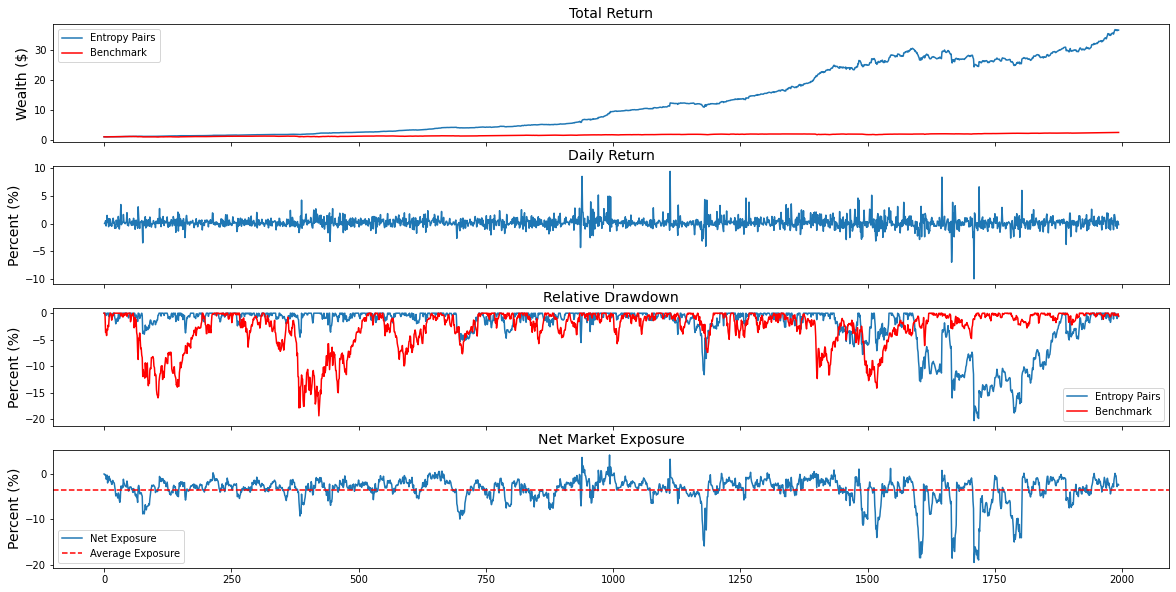

In [18]:
plot_portfolio_performance_summary(portfolio_df_train, sp500_train)

## Training Sample Calendar Summary

In [19]:
strategy_labels = ['Strategy', 'SP500']
wealth_train = portfolio_df_train['wealth'].unstack().sum(axis=1)
strategy_list_train = [wealth_train, sp500_train]
statistics_labels = ['Return (%)', 'Volatility (%)', 'Sharpe', 'Drawdown (%)']
statistics_functions = [calculate_ann_return, calculate_ann_std, 
                        calculate_Sharpe, calculate_max_drawdown]


calendar_summary_df_train = calculate_calendar_summary(strategy_list_train,
                                                       strategy_labels, 
                                                       statistics_labels, 
                                                       statistics_functions)
calendar_summary_df_train

Date                     2010-12-31  2011-12-31  2012-12-31  2013-12-31  \
statistic      strategy                                                   
Return (%)     Strategy       56.86       65.72       71.75       98.51   
               SP500          18.84        1.59       12.73       27.25   
Volatility (%) Strategy       18.38       20.61       18.39       35.64   
               SP500          21.74       23.99       14.37       13.79   
Sharpe         Strategy        3.09        3.19        3.90        2.76   
               SP500           0.87        0.07        0.89        1.98   
Drawdown (%)   Strategy       -3.97       -4.53       -5.40       -5.55   
               SP500         -15.99      -19.39       -9.94       -5.76   

Date                     2014-12-31  2015-12-31  2016-12-31  2017-12-31  
statistic      strategy                                                  
Return (%)     Strategy       64.88       83.51       10.99       41.01  
               SP500          13.16        0.51       12.23       18.84  
Volatility (%) Strategy       30.98       31.72       27.32       21.21  
               SP500          12.88       15.70       14.67        7.91  
Sharpe         Strategy        2.09        2.63        0.40        1.93  
               SP500           1.02        0.03        0.83        2.38  
Drawdown (%)   Strategy      -11.62       -7.79      -20.29       -9.42  
               SP500          -7.40      -12.35       -9.30       -2.80

## Training Sample Rolling Window Summary

In [20]:
window_summary_df_train = calculate_window_summary(strategy_list_train,
                                                   strategy_labels, 
                                                   statistics_labels[:-1],
                                                   statistics_functions[:-1])
window_summary_df_train

1-Year  3-Year  5-Year  10-Year  Since Inception
statistic      strategy                                                  
Return (%)     Strategy   63.79   69.31   68.51    59.57            59.73
               SP500      13.07   13.03   12.93    12.87            13.24
Volatility (%) Strategy   26.66   28.28   28.43    27.19            26.57
               SP500      15.91   16.07   16.15    16.71            16.74
Sharpe         Strategy    2.42    2.50    2.43     2.19             2.25
               SP500       0.93    0.82    0.81     0.77             0.79

## Training Sample Portfolio Returns

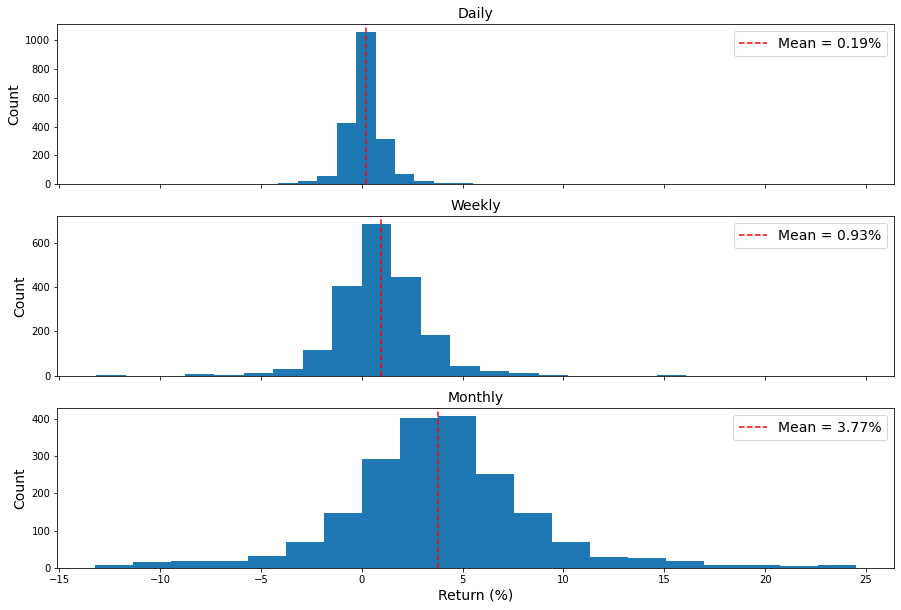

In [21]:
plot_pairs_hist(portfolio_df_train)

## Test Sample

## Plot Test Sample Performance

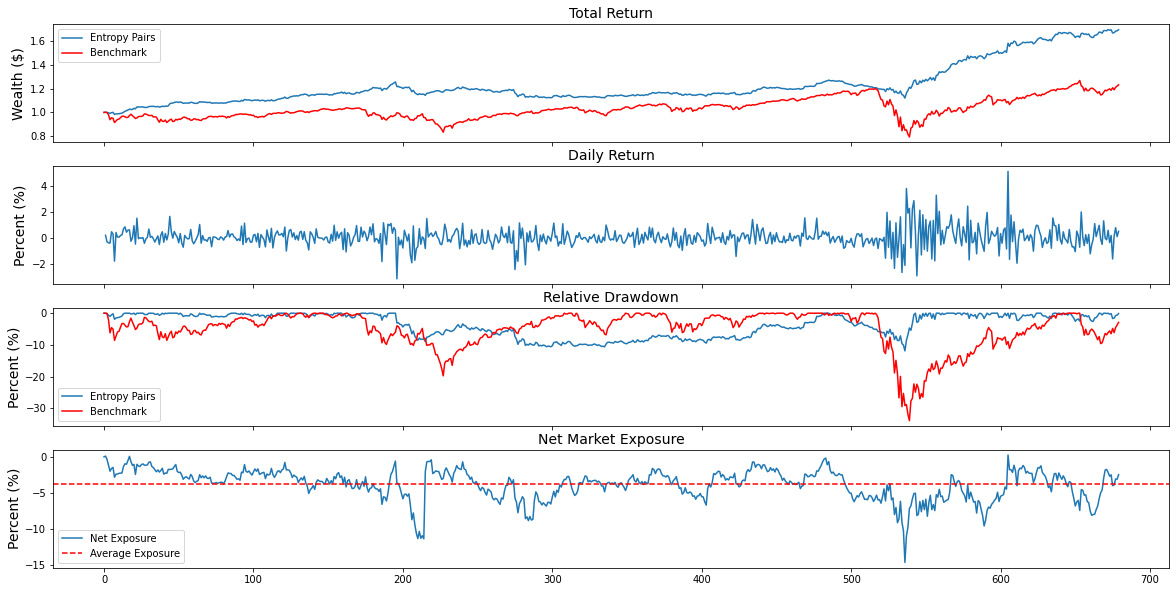

In [22]:
plot_portfolio_performance_summary(portfolio_df_test, sp500_test)

## Test Sample Calendar Summary

In [23]:
wealth_test = portfolio_df_test['wealth'].unstack().sum(axis=1)
strategy_list_test =[wealth_test, sp500_test]
calendar_summary_df_test = calculate_calendar_summary(strategy_list_test,
                                                      strategy_labels, 
                                                      statistics_labels, 
                                                      statistics_functions)
calendar_summary_df_test

Date                     2018-12-31  2019-12-31  2020-12-31
statistic      strategy                                    
Return (%)     Strategy       21.10        7.13       48.02
               SP500         -10.77       29.85       17.09
Volatility (%) Strategy       11.08        8.70       25.29
               SP500          15.77       16.27       46.48
Sharpe         Strategy        1.90        0.82        1.90
               SP500          -0.68        1.83        0.37
Drawdown (%)   Strategy       -8.93       -7.51      -11.91
               SP500         -19.78       -6.84      -33.92

## Test Sample Rolling Window Summary

In [24]:
window_summary_df_test = calculate_window_summary(strategy_list_test,
                                                  strategy_labels, 
                                                  statistics_labels[:-1],
                                                  statistics_functions[:-1])
window_summary_df_test

1-Year  3-Year  5-Year  10-Year  Since Inception
statistic      strategy                                                  
Return (%)     Strategy   14.30     NaN     NaN      NaN            22.48
               SP500      11.03     NaN     NaN      NaN            11.26
Volatility (%) Strategy   12.60     NaN     NaN      NaN            14.32
               SP500      23.89     NaN     NaN      NaN            27.23
Sharpe         Strategy    0.88     NaN     NaN      NaN             1.57
               SP500       0.52     NaN     NaN      NaN             0.41

## Test Sample Portfolio Returns

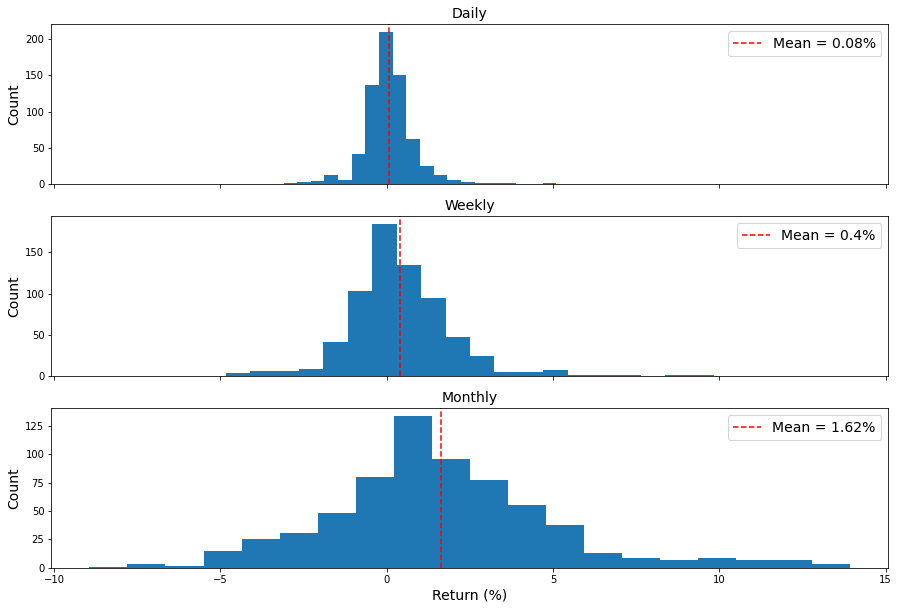

In [25]:
plot_pairs_hist(portfolio_df_test)

# Conclusion
In this research, a profitable trading strategy was demonstrated utilizing mean reverting nonlinear relationships between U.S. equities. The mutual information between security prices was calculated as a measure of generalized correlation. Securities with high mutual information scores were selected and nonlinear relationships were estimated through cross-validated polynomial regression. Rigorous testing was conducted to filter the potential pairs to pairs that obtained mean reverting and stationary spreads. From these desirable spreads, trade signals were generated. In-sample and out-of-sample backtests were performed with promising results. Unsurprisingly, there was degradation in the strategy performance on unseen data. However, the portfolio dominated the benchmark on out-of-sample data still.

Many improvements can be made to this research. For example, increasing the number of securities sampled to generate potential pairs. Implementation of various portfolio optimization techniques at the total wealth level to allocate greater percentage of wealth to more profitable pair portfolios. Increasing the grid search and cross validation folds. 


# Works Cited
<ol>
    <li>López de Prado, M. (2020). Machine Learning for Asset Managers (Elements in Quantitative Finance). Cambridge: Cambridge University Press.</li>
</ol>